## 라이브러리

In [127]:
#modified this original code -> https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification
import numpy as np
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))

['test1', 'train']


## 상수 정의

In [128]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## 트레이닝 데이터 준비

In [129]:
filenames = os.listdir("../input/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [130]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


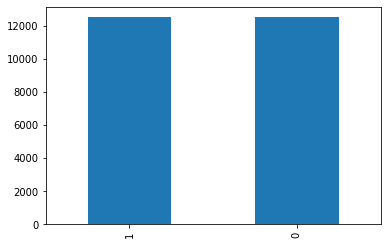

In [131]:
df['category'].value_counts().plot.bar()

## 샘플 이미지 보기

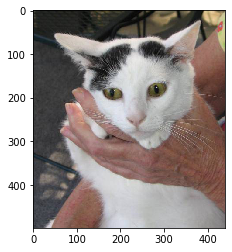

In [132]:
sample = random.choice(filenames)
image = load_img("../input/train/train/"+sample)
plt.imshow(image)

## 모델 만들기

In [133]:
import tensorflow.keras.backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

In [134]:
def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

In [135]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', precision, recall] )

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 64)       

## 학습 멈추기 조건

In [136]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [137]:
earlystop = EarlyStopping(patience=10)

In [138]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [139]:
callbacks = [earlystop, learning_rate_reduction]

## 학습 데이터 준비

In [140]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [141]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

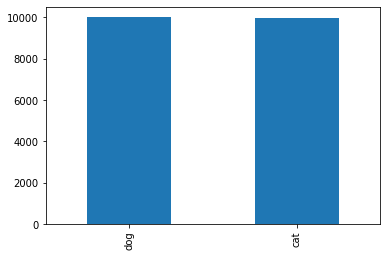

In [142]:
train_df['category'].value_counts().plot.bar()


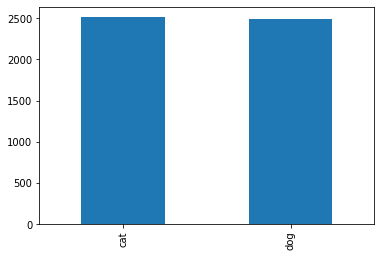

In [143]:
validate_df['category'].value_counts().plot.bar()

In [144]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## 이미지 제너레이터 생성

In [145]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [146]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [147]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


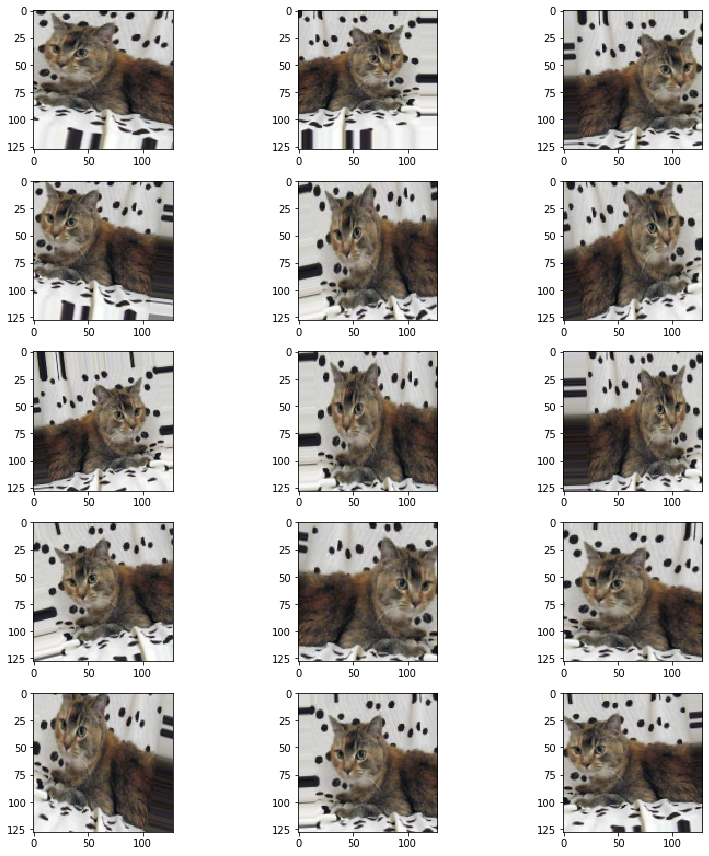

In [148]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 모델 학습시키기

In [149]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/3
1333/1333 [==============================] - 881s 661ms/step - loss: 0.7448 - accuracy: 0.6341 - precision: 0.6340 - recall: 0.6340 - val_loss: 0.6306 - val_accuracy: 0.6749 - val_precision: 0.6749 - val_recall: 0.6749 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 851s 638ms/step - loss: 0.5713 - accuracy: 0.7083 - precision: 0.7083 - recall: 0.7083 - val_loss: 0.4919 - val_accuracy: 0.7564 - val_precision: 0.7564 - val_recall: 0.7564 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 844s 633ms/step - loss: 0.5221 - accuracy: 0.7474 - precision: 0.7474 - recall: 0.7474 - val_loss: 0.6312 - val_accuracy: 0.7449 - val_precision: 0.7449 - val_recall: 0.7449 - lr: 0.0010


## 모델 저장

In [150]:
model.save_weights("model.h5_1")

## 학습 시각화

In [151]:
history.history

{'loss': [0.7448166012763977, 0.5712569355964661, 0.5221007466316223],
 'accuracy': [0.6341255903244019, 0.7082812190055847, 0.7473605275154114],
 'precision': [0.6340071558952332, 0.7083249688148499, 0.7473848462104797],
 'recall': [0.6340071558952332, 0.7083249688148499, 0.7473848462104797],
 'val_loss': [0.6306409239768982, 0.4918630123138428, 0.6311916708946228],
 'val_accuracy': [0.6748749017715454, 0.7563563585281372, 0.7449449300765991],
 'val_precision': [0.6748762726783752, 0.7563580274581909, 0.744946300983429],
 'val_recall': [0.6748762726783752, 0.7563580274581909, 0.744946300983429],
 'lr': [0.001, 0.001, 0.001]}

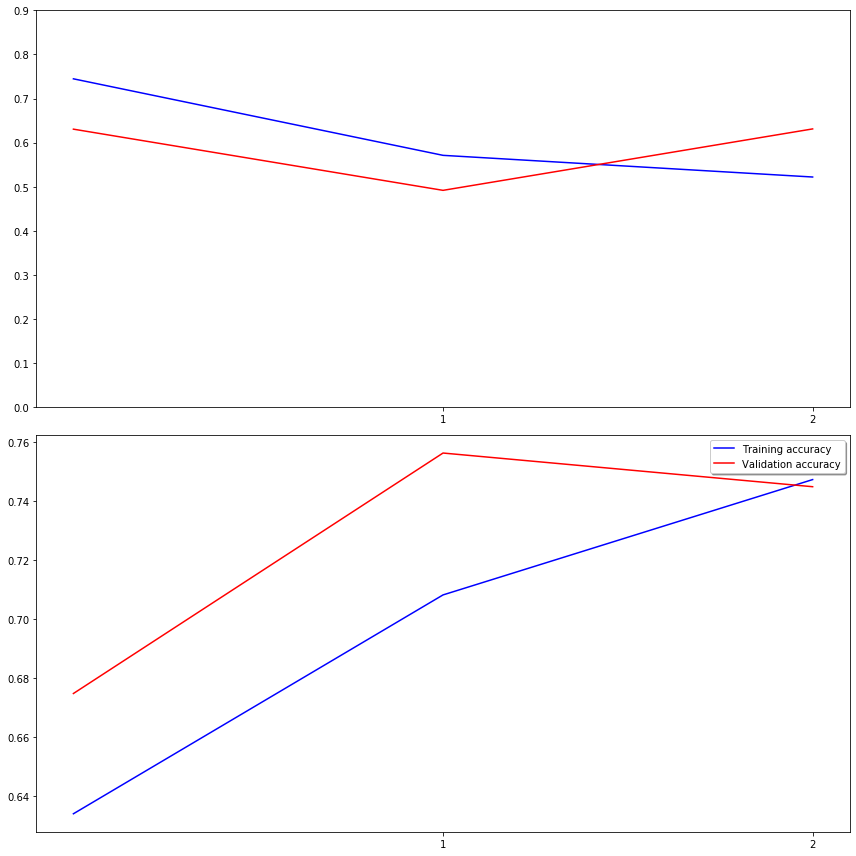

In [152]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## 테스트 데이터 준비

In [153]:
test_filenames = os.listdir("../input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## 테스트 이미지

In [154]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## 예측하기

In [156]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [157]:
test_df['category'] = np.argmax(predict, axis=-1)

In [158]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [159]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [164]:
test_df['category'].value_counts()

0    6866
1    5634
Name: category, dtype: int64

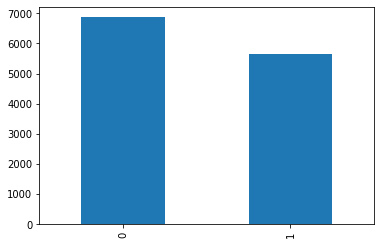

In [160]:
test_df['category'].value_counts().plot.bar()

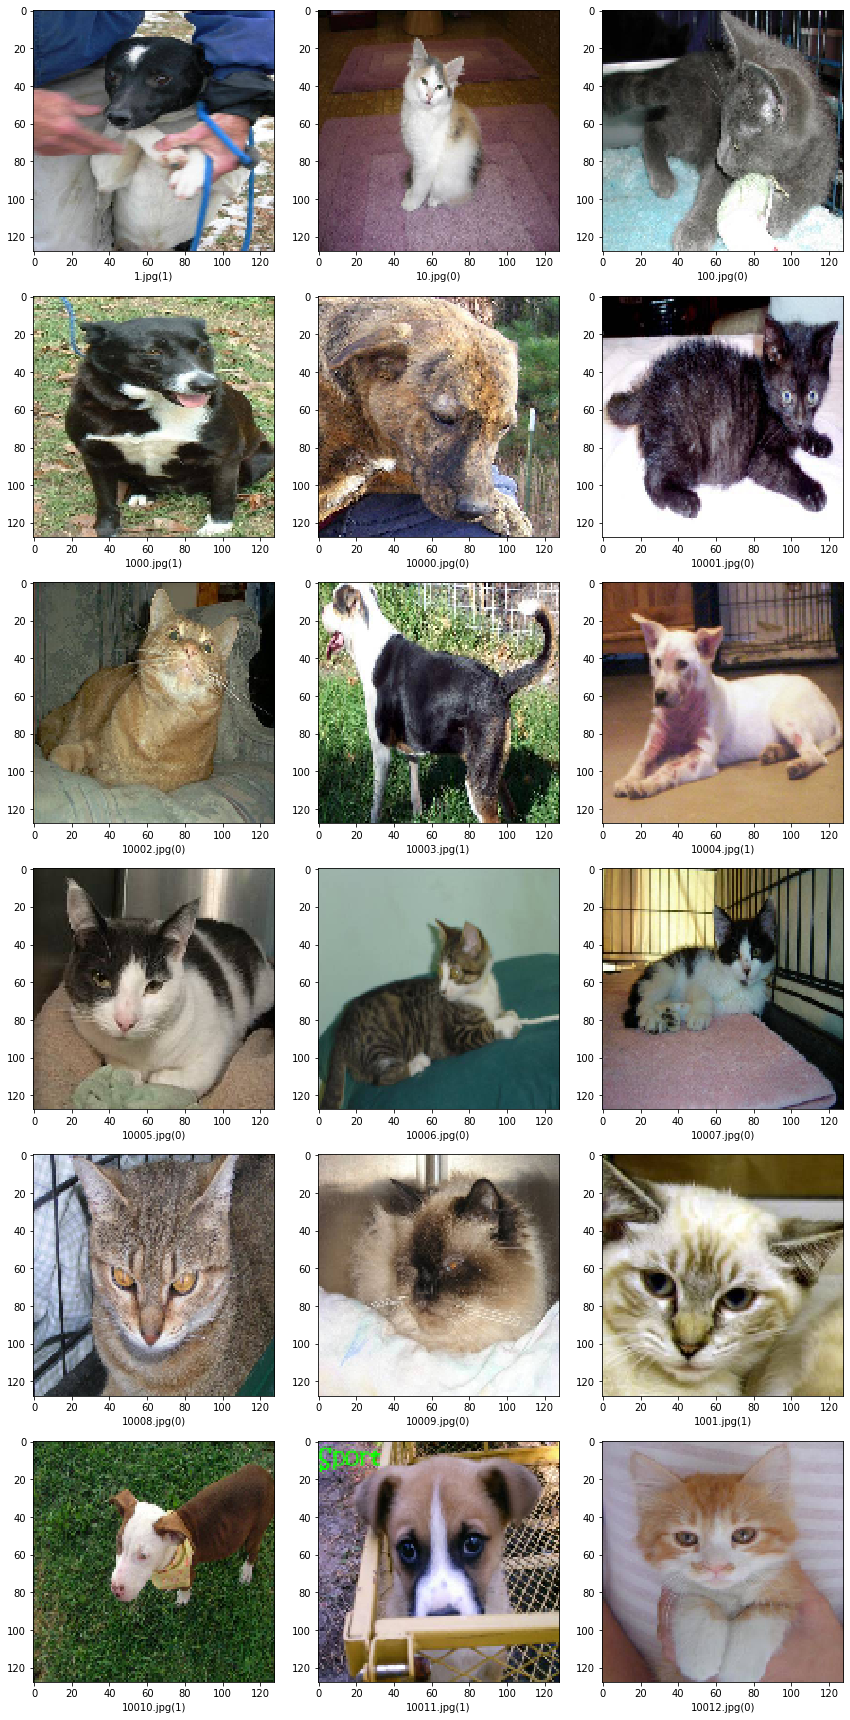

In [161]:
#이미지를 불러와 실제 예측이 맞나 확인
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()